In [1]:
import numpy as np
import pandas as pd

from matplotlib import style
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-ticks')

from algo import VectorizedBT

In [2]:
df = pd.read_parquet('data.parquet')
df.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


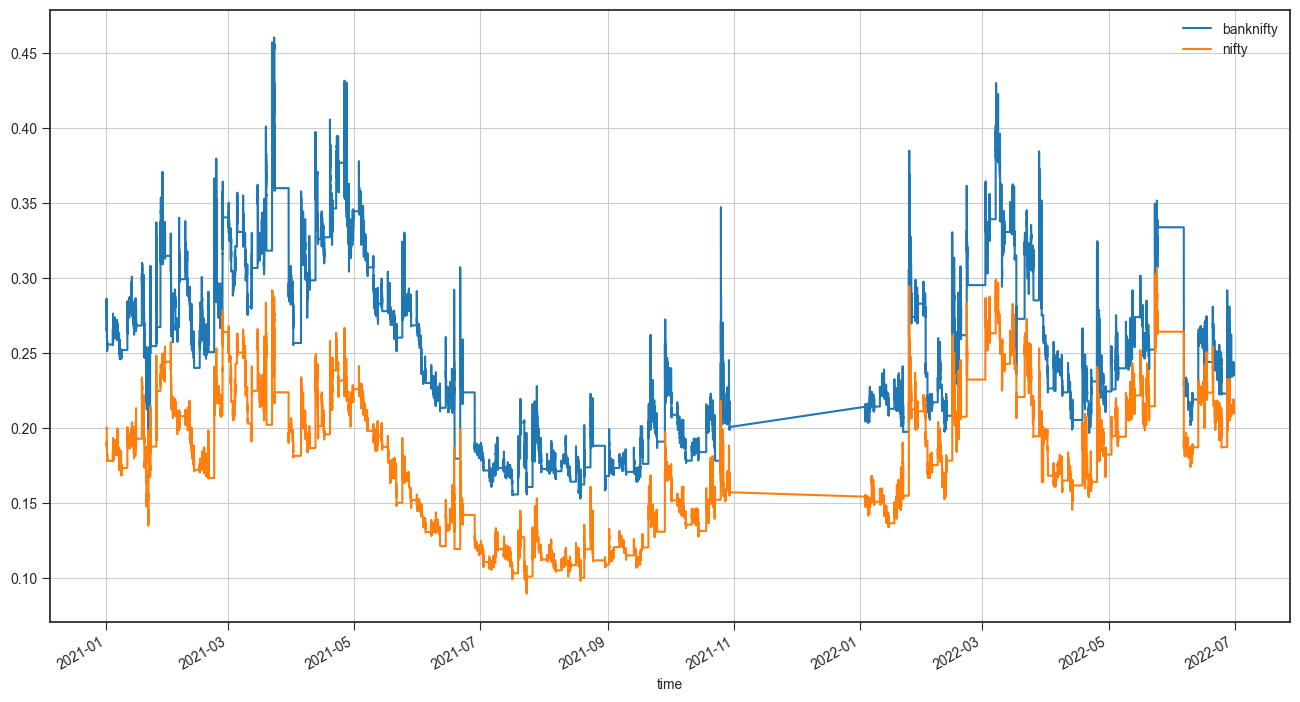

In [3]:
df = df.dropna()
df[['banknifty', 'nifty']].plot(figsize=(16,9), grid=True);

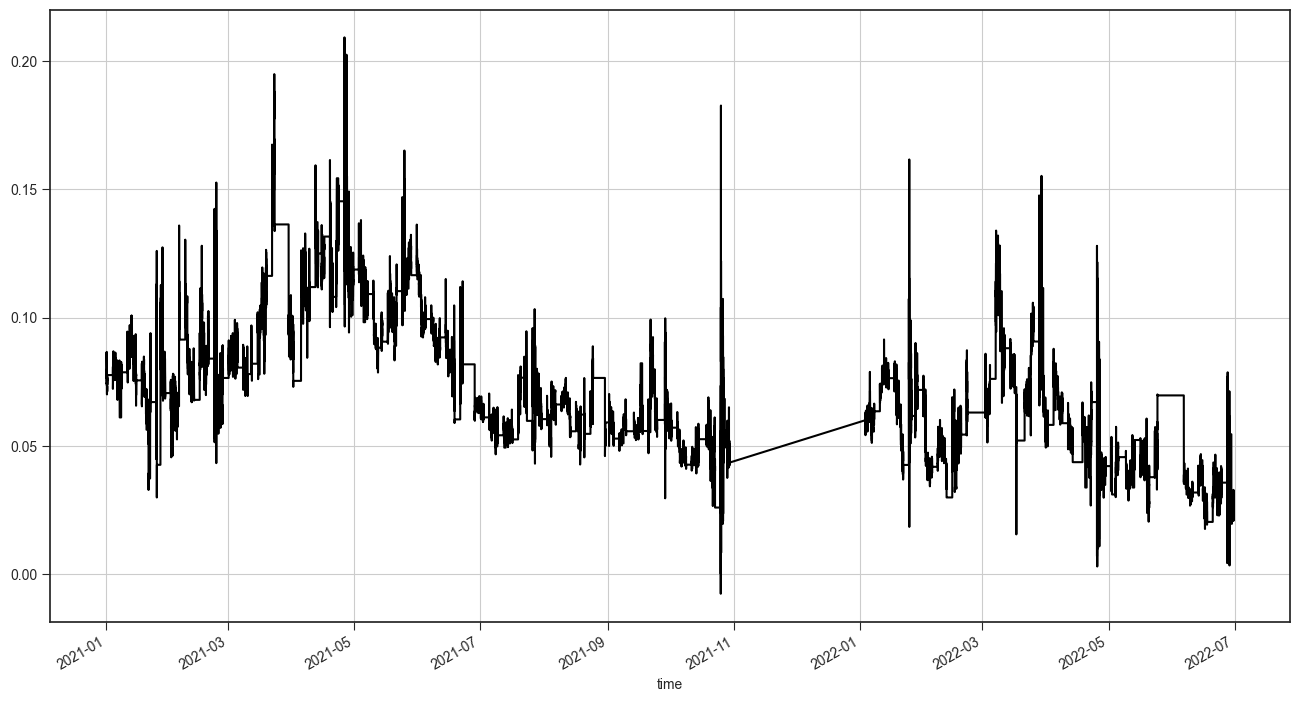

In [4]:
spread = df['banknifty'] - df['nifty']
spread.name = 'spread'
PL = spread*(df['tte']**0.7)
PL.name = 'PL'
spread.plot(figsize=(16,9), color='black', grid=True);

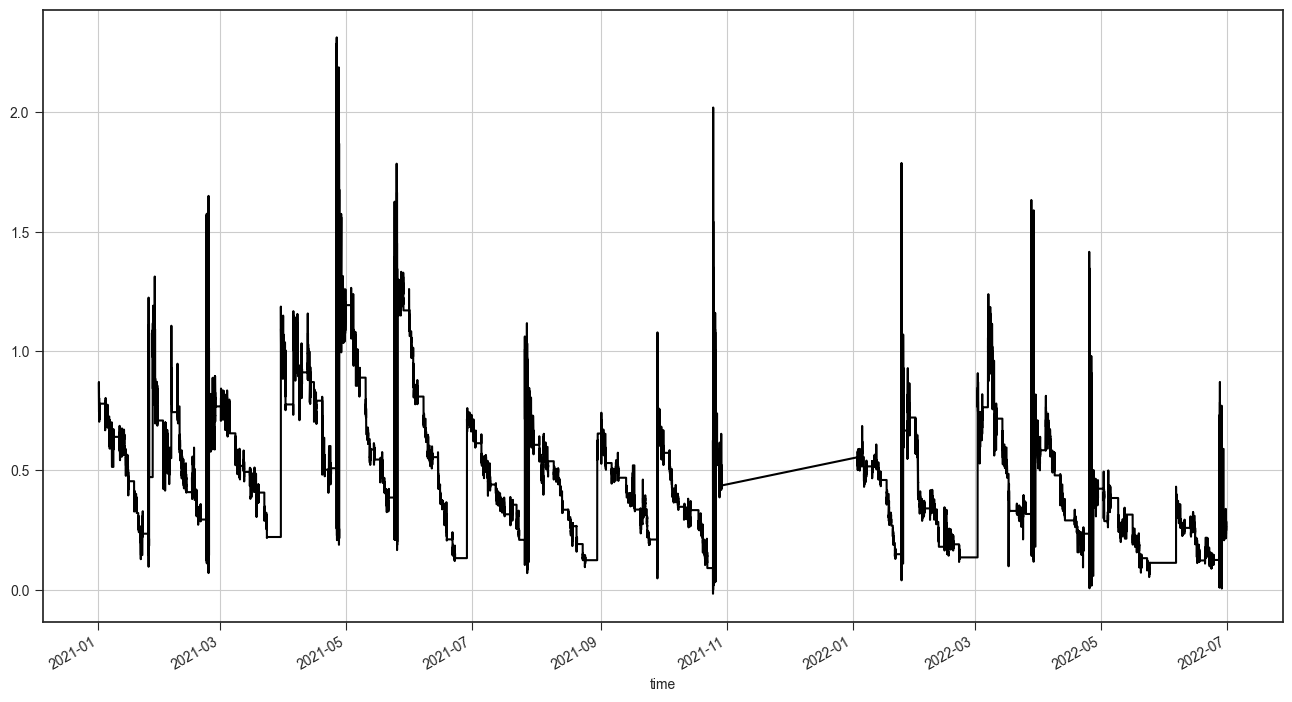

In [5]:
PL.plot(figsize=(16,9), color='black', grid=True);

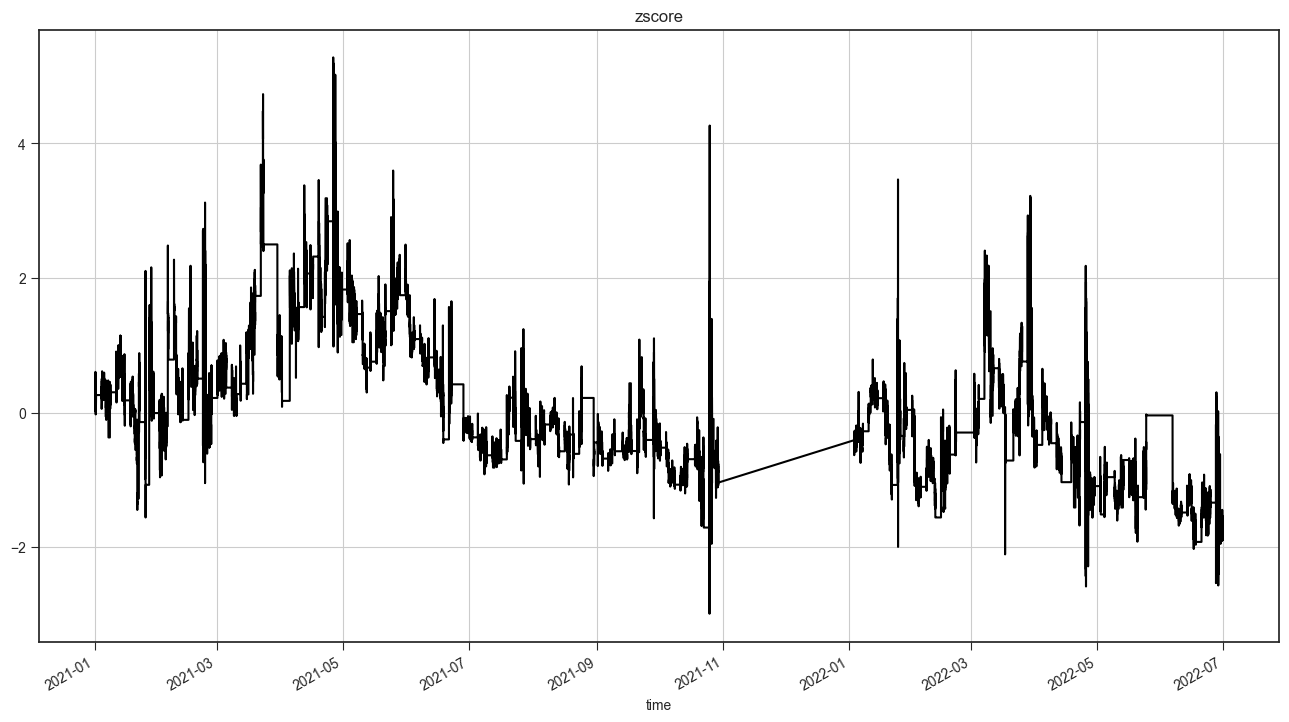

In [6]:
zscore = (spread - spread.mean()) / np.std(spread)
zscore.plot(figsize=(16,9), color='black', grid=True, title='zscore');

In [7]:
class ZScoreStrategy(VectorizedBT):
    def __init__(self, df, window_size=120, entry_level=2, exit_level=0):
        super(ZScoreStrategy, self).__init__()
        self.spread = df['banknifty'] - df['nifty']
        self.PL = self.spread*(df['tte']**0.7)
        self.window = window_size
        mavg = self.spread.rolling(self.window).mean()
        std = self.spread.rolling(self.window).mean().std()
        self.rolling_zscore = ((self.spread - mavg)/std).dropna()
        self.entry_level = entry_level
        self.exit_level = exit_level
        
    def get_signals(self):
        #convert to numpy array for faster computation
        zscore = np.asarray(self.rolling_zscore)
        # get indices for long and short positions
        longs_entry = zscore < -self.entry_level
        longs_exit = zscore > -self.exit_level
        shorts_entry = zscore > self.entry_level
        shorts_exit = zscore < self.exit_level
        #pandas series for storing long short signals
        num_units_long = pd.Series([np.nan for i in range(len(zscore))])
        num_units_short = pd.Series([np.nan for i in range(len(zscore))])
        # set threshold crossings with corresponding position
        num_units_long[longs_entry] = 1.
        num_units_long[longs_exit] = 0
        num_units_short[shorts_entry] = -1.
        num_units_short[shorts_exit] = 0
        # shift to simulate entry delay (of 1 min) in real life trading
        num_units_long = num_units_long.shift(1)
        num_units_short = num_units_short.shift(1)
        # initialize market position with zero
        num_units_long[0] = 0.
        num_units_short[0] = 0.
        # finally, fill in between
        num_units_long = num_units_long.fillna(method='ffill')
        num_units_short = num_units_short.fillna(method='ffill')
        num_units = num_units_long + num_units_short
        #signals series
        signals = pd.Series(0, index=df.index, name='signals')
        signals[self.rolling_zscore.index] = num_units
        return signals

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :               320.01
      Sharpe Ratio :                 5.44
  Max. Drawdown P&L:                -6.64


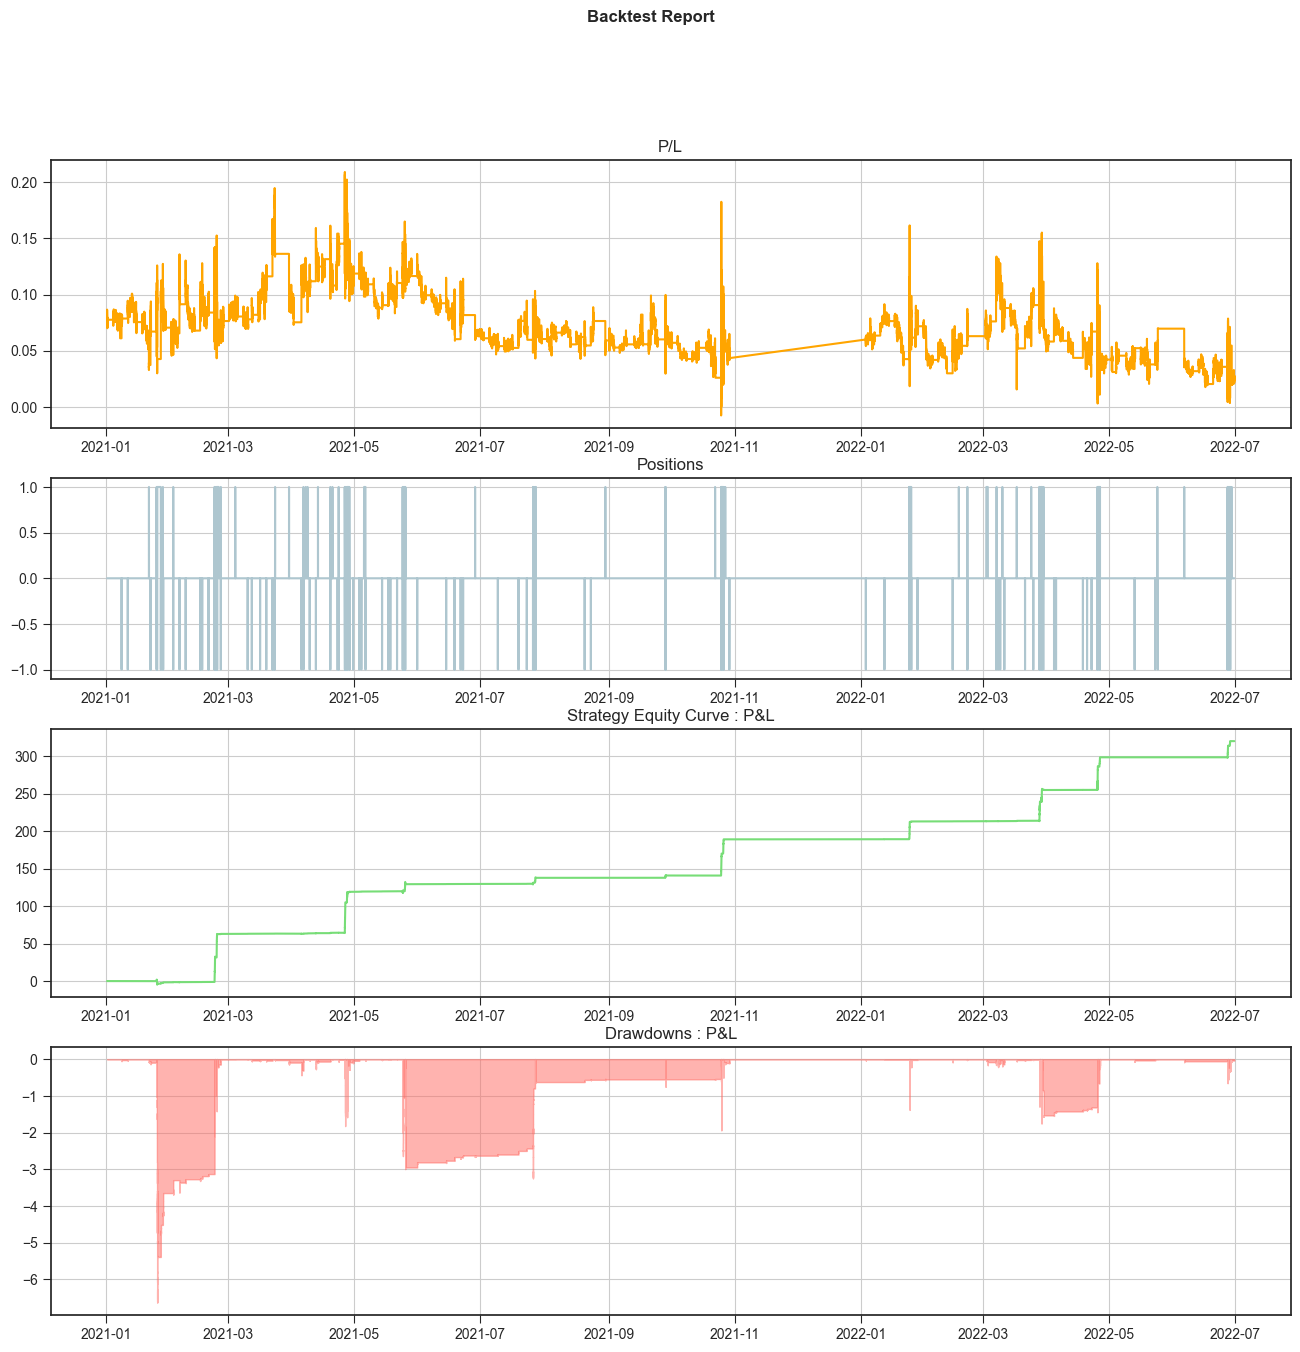

In [8]:
strat = ZScoreStrategy(df, 30, entry_level=0.5)
strat.run()
strat.get_perf_stats()

In [9]:
class QuintileStrategy(VectorizedBT):
    def __init__(self, df, window_size=30, higher_quintile=0.9, lower_quintile=0.1):
        super(QuintileStrategy, self).__init__()
        self.spread = df['banknifty'] - df['nifty']
        self.PL = self.spread*(df['tte']**0.7)
        self.window = window_size
        self.thres = df.copy()
        self.thres['PL'] = self.PL
        self.thres['diff'] = self.PL.diff()
        self.higher_quintile = higher_quintile
        self.lower_quintile = lower_quintile
        
    def get_signals(self):
        self.thres['upper_threshold'] = self.thres['PL'] + self.thres['diff'].rolling(self.window, min_periods=self.window, step=self.window).quantile(self.higher_quintile, interpolation='linear')
        self.thres['lower_threshold'] = self.thres['PL'] + self.thres['diff'].rolling(self.window, min_periods=self.window, step=self.window).quantile(self.lower_quintile, interpolation='linear')
        self.thres = self.thres.fillna(method='ffill')
        self.thres['exit_threshold'] = self.thres['PL'] + self.thres['diff'].rolling(self.window, min_periods=self.window, step=self.window).quantile(.5, interpolation='linear')
        short_entry = self.thres['PL'] > self.thres['upper_threshold']
        long_entry = self.thres['PL'] < self.thres['lower_threshold']
        short_exit = self.thres['PL'] < self.thres['exit_threshold']
        long_exit = self.thres['PL'] > self.thres['exit_threshold']
        self.thres['signals'] = np.nan
        self.thres.loc[short_entry, 'signals'] = 1
        self.thres.loc[short_exit, 'signals'] = 0
        self.thres.loc[long_entry, 'signals'] = -1
        self.thres.loc[long_exit, 'signals'] = 0
        self.thres['signals'] = self.thres['signals'].fillna(method='ffill')
        self.thres['signals'] = self.thres['signals'].fillna(0)
        return self.thres['signals']

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :               469.16
      Sharpe Ratio :                 7.06
  Max. Drawdown P&L:                -1.88


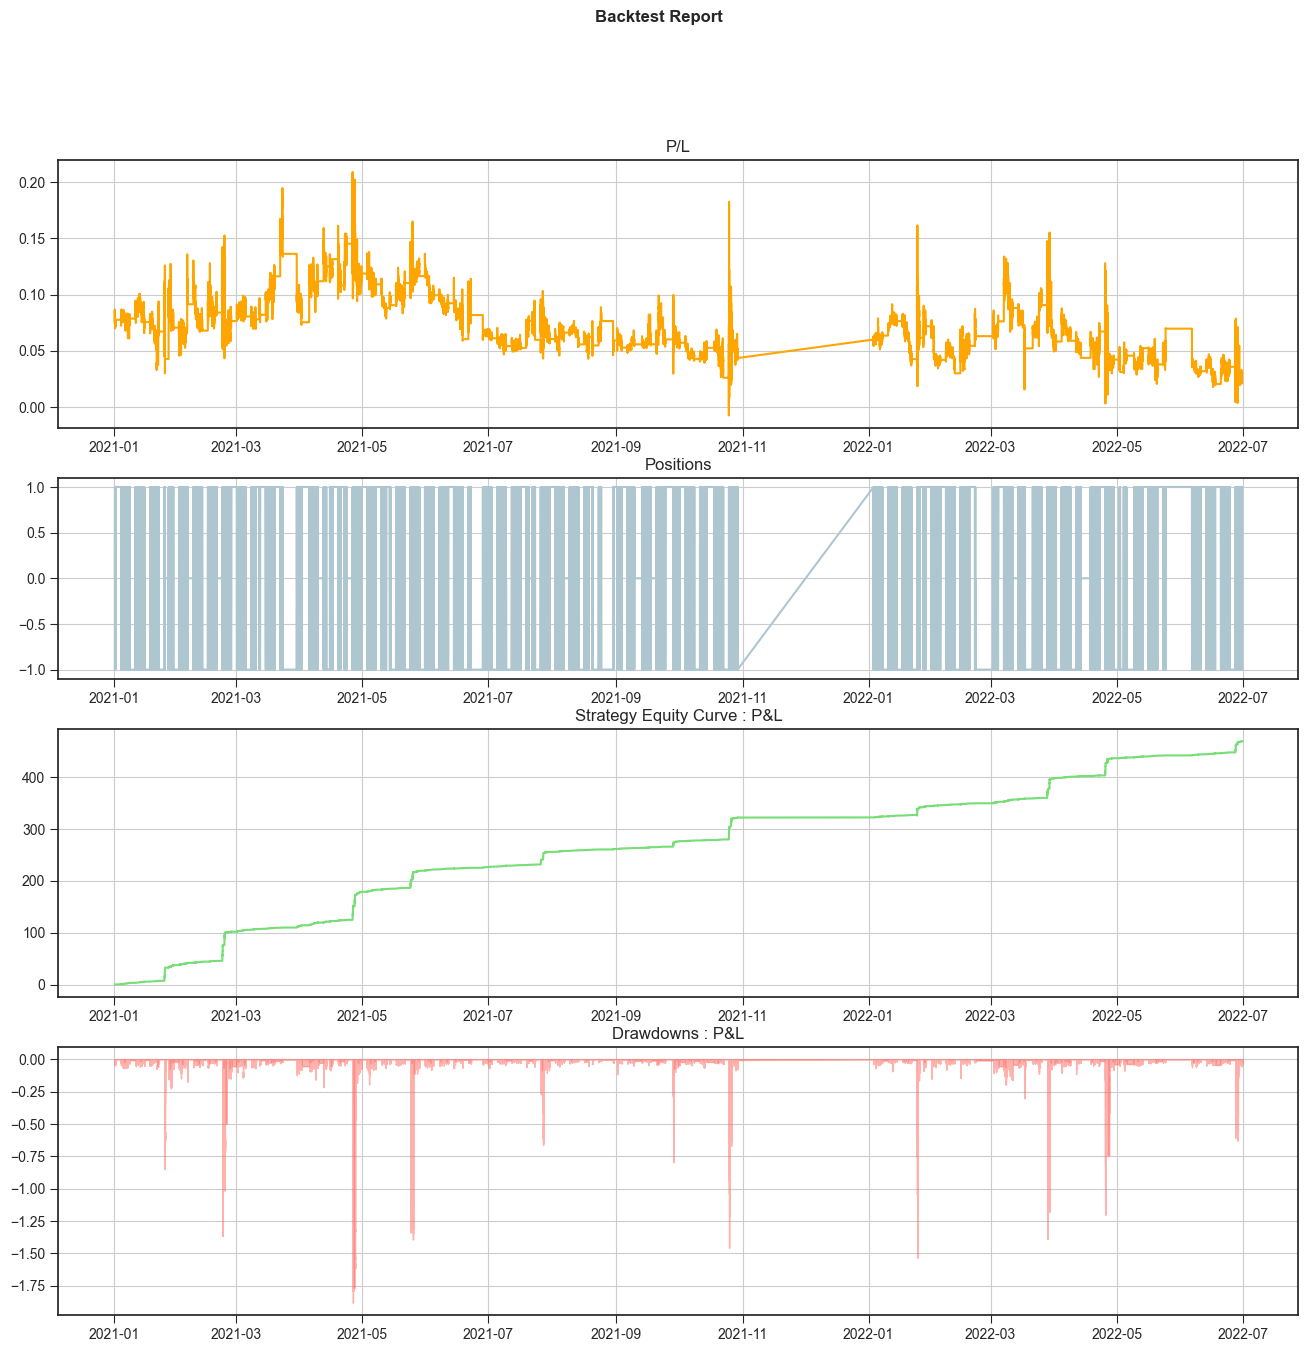

In [10]:
strat = QuintileStrategy(df, 30, 0.75, 0.25)
strat.run()
strat.get_perf_stats()